## Space Weather Analysis

Adam Benson

This notebook looks at various indices of Space Weather as provided by the OMNI data resource. Specifically, I will be analyzing the relationship between the BZ and Ey indices.

In [1]:
import numpy as np                              # for numerical precision 
import datetime as dt                           # for datetime objects
import matplotlib.pyplot as plt                 # for plotting
import pandas as pd                             # for data structures/analysi
from   scipy import stats                       # for linear regression
import matplotlib.dates as mdt                  # for manipulation of dates in matplotlib
from   matplotlib.ticker import MultipleLocator # for pretty plotting
import matplotlib.image as mpimg                # for manipulation of img files
                                                # in plotting environments
import importlib                                # for reimporting libaries / package
import linerror as lr                           # for calculating linear
                                                # fits
        
from   matplotlib.patches import Rectangle      #for plotting rectangles
                                                
    
import externalfunctions as extFunc             #for easy importing
                                                
    
from   sklearn.metrics import confusion_matrix  #NEW IN THIS LAB
                                                #for confusion matrix
#for plotting in notebook
%matplotlib inline

### Data Sources

Solar Dynamic Observatory Data : https://sdo.gsfc.nasa.gov/  <br>

Near Earth Data (Hourly OMNI Data): https://omniweb.gsfc.nasa.gov/html/ow_data.html#1 <br> <br>
Description: 1963-to-current compilation of hourly-averaged, near-Earth solar wind magnetic field and plasma parameter data from several spacecraft in geocentric or L1 (Lagrange point) orbits. The data have been extensively cross compared, and, for some spacecraft and parameters, cross-normalized. Time-shifts of higher resolution data to expected magnetosphere-arrival times are done for data from spacecraft in L1 orbits (ISEE 3, Wind, ACE), prior to taking hourly averages.

## Goal

Analyze how any of the indices on the Omni website correlate to any of the other quantities on Omni (magnetic field, plasma data, derived parametes)

### Scientific Question

Is the Bz component of the interplanetary magnetic field highly correlated with the duskward electric field (Ey)?

### Loading and Visualizing Image Data of the Sun

In [2]:
## Found a period of activity!

# 12PM, August 20th, 2010 Sun activity
activeSun = mpimg.imread('./Images/20100820_123001_512_0171.jpg')
activeSunred = mpimg.imread('./Images/20100820_121509_512_0304.jpg')

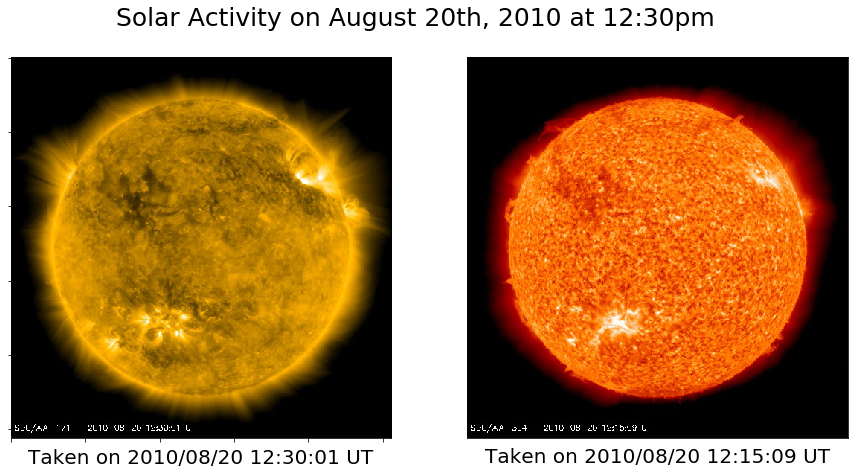

In [3]:
## looking at the sun on August 20th, 2010.
## this is a fun plot that looks at two pictures of the sun during an active period

# creating figure and specifying size
fig = plt.figure(figsize=(15,7))

## creating two subplots
gs = plt.GridSpec(1, 2, hspace=0.1, wspace=0.2, right = 0.9)

plt.suptitle("Solar Activity on August 20th, 2010 at 12:30pm", fontsize=25)

#add subplots
ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[:,1])

#make aspect ratio better - 1.0 is square. Feel free to play around with these
#and see how it streches.
ax1.set_aspect(1.0)
ax2.set_aspect(1.0)

#plot images data - note for now use imshow to plot out the 3D datasets

ax1.imshow(activeSun)
ax2.imshow(activeSunred)

#setting labeling
ax1.set_xlabel('Taken on 2010/08/20 12:30:01 UT',   fontsize = 20)
ax2.set_xlabel('Taken on 2010/08/20 12:15:09 UT', fontsize = 20, labelpad=10)

#setting tick parameters to null - these are just pixel values so in this case, not
#incredibly informative
ax1.set_xticklabels([]) #make the tick labels
ax2.set_xticklabels([])

ax1.set_yticklabels([]) #make the tick labels
ax2.set_yticklabels([])

plt.xticks([])
plt.yticks([])

plt.savefig("Solar_Activity.png")

plt.show()

### Loading Data

Near Earth Data

In [4]:
## defining names for columns
colNames = ['YEAR', 'DOY', 'Hour', 'BX', 'BY', 'BZ', 'FlowPressure', 'Ey', 'Kp', 
            'SunspotNumber', 'Dst', 'f10.7_index']

## reading in data
hourOmni = pd.read_csv('./Data/omni2_Hourly1980_2018.lst', sep = '\s+', names = colNames,
                          parse_dates = {'Datetime': colNames[0:3]}, keep_date_col = 'True')

## creating datetime index
hourOmni.index = pd.to_datetime(hourOmni['Datetime'], infer_datetime_format = False, 
                                   format = '%Y %j %H')

### Inspecting Data

In [5]:
## Near Earth Data 
# first five records
hourOmni.head()

,Datetime,YEAR,DOY,Hour,BX,BY,BZ,FlowPressure,Ey,Kp,SunspotNumber,Dst,f10.7_index
Datetime,,,,,,,,,,,,,
1980-01-01 00:00:00,1980 1 0,1980,1,0,-5.3,5.2,3.4,1.43,-1.89,23,217,-27,189.1
1980-01-01 01:00:00,1980 1 1,1980,1,1,-6.3,4.6,2.5,1.66,-1.41,23,217,-20,189.1
1980-01-01 02:00:00,1980 1 2,1980,1,2,-4.6,7.0,-1.5,1.55,0.04,23,217,-23,189.1
1980-01-01 03:00:00,1980 1 3,1980,1,3,-5.4,6.8,-2.1,1.40,0.44,23,217,-28,189.1
1980-01-01 04:00:00,1980 1 4,1980,1,4,-5.4,6.9,-2.4,0.87,0.72,23,217,-32,189.1


In [6]:
# last five records
hourOmni.tail()

,Datetime,YEAR,DOY,Hour,BX,BY,BZ,FlowPressure,Ey,Kp,SunspotNumber,Dst,f10.7_index
Datetime,,,,,,,,,,,,,
2018-02-26 19:00:00,2018 57 19,2018,57,19,999.9,999.9,999.9,99.99,999.99,99,999,6,68.4
2018-02-26 20:00:00,2018 57 20,2018,57,20,999.9,999.9,999.9,99.99,999.99,99,999,5,68.4
2018-02-26 21:00:00,2018 57 21,2018,57,21,999.9,999.9,999.9,99.99,999.99,99,999,6,68.4
2018-02-26 22:00:00,2018 57 22,2018,57,22,999.9,999.9,999.9,99.99,999.99,99,999,11,68.4
2018-02-26 23:00:00,2018 57 23,2018,57,23,999.9,999.9,999.9,99.99,999.99,99,999,8,68.4


### Cleaning Data

In [7]:
## Note: NaN Values are 999 for some reason. This will influence calculations so we must remove them.

#because the data has different format - we replace the similarly formatter
#columns with each of the retrospective nan values.

hourOmni[['BX', 'BY', 'BZ', 'f10.7_index']] = hourOmni[[
    'BX', 'BY', 'BZ', 'f10.7_index']].replace(to_replace = 999.9, value = np.nan)

hourOmni['FlowPressure'] = hourOmni['FlowPressure'].replace(
    to_replace = 99.99, value = np.nan)

hourOmni['Ey'] = hourOmni['Ey'].replace(to_replace = 999.99, value = np.nan)

hourOmni[['SunspotNumber', 'Kp']] = hourOmni[['SunspotNumber', 'Kp']].replace(
    to_replace = 999, value = np.nan)


### Time Series Plot

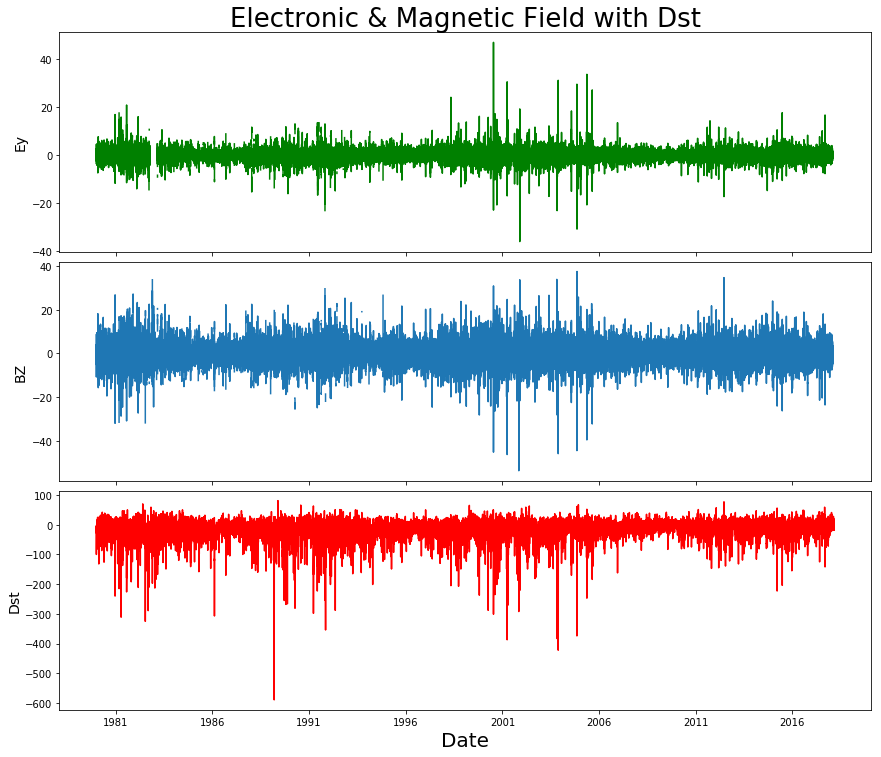

In [8]:
## time series plot of three OMNI indices (Ey, BZ, and Dst)

## making figure and three subplots using a method other than GridSpec
fig , ax = plt.subplots(ncols=1, nrows=3, figsize=(12,10), sharex=True)

## minimizing horizontal distance between subplots
plt.tight_layout(h_pad=0)

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]

ax1.set_ylabel("Ey", fontsize=14)
ax2.set_ylabel("BZ", fontsize=14)
ax3.set_ylabel("Dst", fontsize=14)

ax1.plot(hourOmni.index, hourOmni['Ey'], color='g')
ax2.plot(hourOmni.index, hourOmni['BZ'])
ax3.plot(hourOmni.index, hourOmni['Dst'], color='r')

ax1.set_title("Electronic & Magnetic Field with Dst", fontsize=26)
plt.xlabel('Date', fontsize=20)
plt.show()

### Exploratory Linear Regression

explanation on Kp : https://www.swpc.noaa.gov/products/planetary-k-index 

using seaborn to investigate relationships between variables

In [9]:
import seaborn as sns   ## statistical plotting

### Dst vs. Electric Field

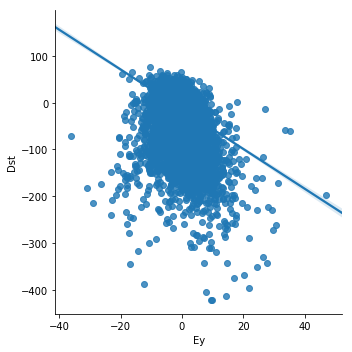

In [10]:
### Dst dependence on Electric Field(Ey) 
# "Hall effect"?

sns.lmplot(x='Ey', y='Dst', data=hourOmni)
plt.show()

Kp vs. Electric Field: Pearson's Linear Correlation

In [11]:
print(np.round(hourOmni['Dst'].corr(hourOmni['Ey'], method='pearson'), 2))

-0.29


### Dst vs. Bz

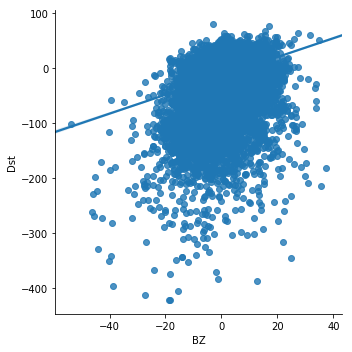

In [12]:
sns.lmplot(x='BZ', y='Dst', data=hourOmni)
plt.show()

# Linear Dependence of BZ on Electric Field

# Bz vs. Electric Field

The interplanetary magnetic field is a vector quantity with a three axis component, two of which (Bx and By) are orientated parallel to the ecliptic. The Bx and By components are not important for auroral activity. The third component, the Bz value, is perpendicular to the ecliptic and is created by waves and other disturbances in the solar wind
https://www.spaceweatherlive.com/en/help/the-interplanetary-magnetic-field-imf 


The most important parameter is Bz, the z–component of the sun's magnetic field. 
When Bz goes negative, the solar wind strongly couples to the Earth's magnetosphere. Think of Bz as the door that allows transferring of significant amounts of energy. The more negative Bz goes, the more energy that can be transferred, resulting in more geomagnetic activity. Other parameters to watch are the density and the solar wind velocity, as these determine just how much energy is transferred when Bz is negative.

http://www.dartmouth.edu/~aurora/spaceweather/spaceweatherguide.html

It is also common to refer to individual elements of the vectors concerned. 

In cartesian
coordinates, we may write the time-dependent electric field E as:
E(x, y, z, t) = [ Ex(x, y, z, t) , Ey(x, y, z, t) , Ez
(x, y, z, t) ]


http://www3.imperial.ac.uk/pls/portallive/docs/1/2475905.PDF

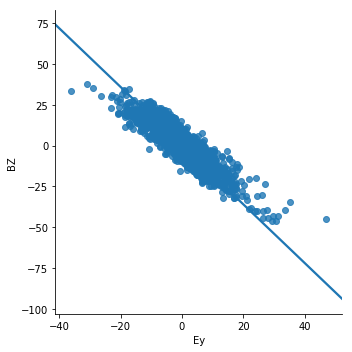

In [13]:
## seaborn exploratory plot

sns.lmplot(x='Ey', y='BZ', data=hourOmni)
plt.show()

### Pearsons's Linear Correlation Coefficient

In [14]:
pearscoeff = np.round(hourOmni['BZ'].corr(hourOmni['Ey'], method='pearson'), 2)

print("Pearson's Linear Correlation between BZ and Ey: {}".format(pearscoeff))

Pearson's Linear Correlation between BZ and Ey: -0.88


### Simple Linear Regression

In [15]:
#since this doesn't work on nan values first we remove all potential nans' 

## removing lines for stats.linregress so that it is not included in calculation
nanMask = ((~np.isnan(hourOmni['Ey'])) & 
           (~np.isnan(hourOmni['BZ'])))

# only taking points where it is not nan
xVals = hourOmni.loc[nanMask, 'Ey']
yVals = hourOmni.loc[nanMask, 'BZ']


# calling prebuilt linear regression model
slope, intercept, rval, pval, stderr = stats.linregress(xVals, yVals)


# calculate the yvalues given the linear fit
# outputting what we would expect the line to look like
yModel = intercept + slope * xVals



### Calculating error on fit

#find y errors
RMSE  = lr.calcRMSE(yModel, yVals)

#error on coefficents, slope and y-intercept and.
errSlope,  errInter = lr.calcCoeffsErr(xVals,  RMSE)


#print out fit report - 
## :.2f limits the number to two decimal places
print("Fit Report: \n \tUncert. on Y: +/- {:.2f}".format(RMSE) + 
      "\n \tIntercept: {:.2f} +/- {:.2f}".format(intercept, errInter)
      + "\n\tSlope: {:.2f} +/- {:.2f}".format(slope, errSlope) 
      + "\n\tPearson linear correlation: {:.2f}, r-squared: {:.2f}".format(rval, rval**2))



Fit Report: 
 	Uncert. on Y: +/- 1.42
 	Intercept: 0.01 +/- 0.00
	Slope: -1.79 +/- 0.00
	Pearson linear correlation: -0.88, r-squared: 0.78


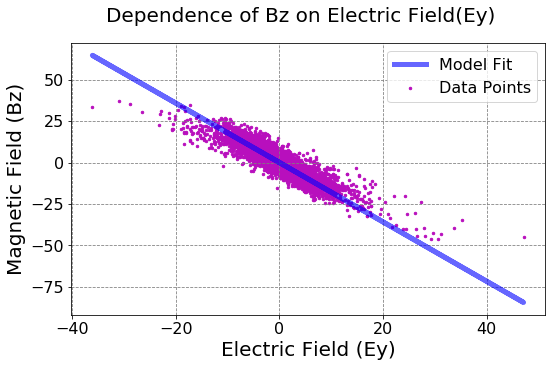

In [16]:
fig = plt.figure(figsize=(8.5, 5))
fig.suptitle('Dependence of Bz on Electric Field(Ey)', fontsize=20)

gs  = plt.GridSpec(1, 1, hspace=0.0, wspace=0.2, right = 0.9)

#add subplots
ax1 = fig.add_subplot(gs[0,0])

#set up titles for axis
ax1.set_xlabel('Electric Field (Ey)', fontsize = 20)
ax1.set_ylabel('Magnetic Field (Bz)', fontsize = 20)

#plot values
ax1.scatter(xVals, yVals,  color = '#B80FBD', s = 6, label="Data Points")
ax1.plot(xVals, yModel, color = 'b', alpha=0.6, lw = 5, label="Model Fit")

#set up grid
ax1.grid(color='gray', linestyle='dashed')

plt.legend(prop={'size': 16})


ax1.tick_params(labelsize = 16)

plt.savefig("Regression.png")

plt.show()

### ROC Curve

In [17]:
#Seting up "Events"

# new column in data frame, populated with zeros
hourOmni['Events'] = np.zeros(len(hourOmni))

# if BZ <0 (is negative) that is an EVENT
DBound = 0

#https://www.spaceweatherlive.com/en/help/the-interplanetary-magnetic-field-imf
    
indEvent = hourOmni['BZ'] < DBound

# where an event, changes Events column to 1
hourOmni.loc[indEvent, 'Events'] = 1

In [18]:
# Creating a threshold above which Ey we might expect a storm to occur
hourOmni['Predict'] = np.zeros(len(hourOmni))

# seting up a boundary above which we want a binary value

FBound = 10
indPredict = hourOmni['Ey'] > FBound
hourOmni.loc[indPredict, 'Predict'] = 1


In [19]:
# np array of threshold values, step=1

thresholdVals = np.arange(-10, 60, 1)


In [20]:
#setting up a dictionary to capture the output from each performance calculations
perfValues = {}

perfValues['POD'] = np.zeros(len(thresholdVals))
perfValues['PFD'] = np.zeros(len(thresholdVals))

#run through threshold values
for i, t in enumerate(thresholdVals):
    print("Running for threshold value of Ey of {}, index {}".format(t, i))
    
    #set up the prediction each time
    hourOmni['Predict'] = np.zeros(len(hourOmni))
    
    indPredict = hourOmni['Ey'] > t
    hourOmni.loc[indPredict, 'Predict'] = 1
    
    #caclulate the confusion matrix values
    N, F, M, H = confusion_matrix(hourOmni['Events'], hourOmni['Predict']).ravel()
    
    skillScore = (2*(H*N-(F*M)))/((H+M)*(F+N)+(H+F)*(N+F))
    print("Heidske Skill Score: {}".format(skillScore))
    
    #find POD, PDF
    perfValues['POD'][i] = extFunc.calcPOD(H, M)
    
    perfValues['PFD'][i] = extFunc.calcPFD(F, N)

Running for threshold value of Ey of -10, index 0
Heidske Skill Score: 0.21215798256079482
Running for threshold value of Ey of -9, index 1
Heidske Skill Score: 0.21238453545843874
Running for threshold value of Ey of -8, index 2
Heidske Skill Score: 0.21283784514891535
Running for threshold value of Ey of -7, index 3
Heidske Skill Score: 0.21350923204850195
Running for threshold value of Ey of -6, index 4
Heidske Skill Score: 0.2146408661420204
Running for threshold value of Ey of -5, index 5
Heidske Skill Score: 0.21666630649328383
Running for threshold value of Ey of -4, index 6
Heidske Skill Score: 0.22130755301732563
Running for threshold value of Ey of -3, index 7
Heidske Skill Score: 0.23281534128647943
Running for threshold value of Ey of -2, index 8
Heidske Skill Score: 0.26772316529352846
Running for threshold value of Ey of -1, index 9
Heidske Skill Score: 0.3928397439452795
Running for threshold value of Ey of 0, index 10
Heidske Skill Score: 0.7471390305755115
Running for 

### Maximum Skill Score:

<strong> Running for threshold value of Ey of 0, index 10

Heidske Skill Score: 0.7471390305755115 </strong>

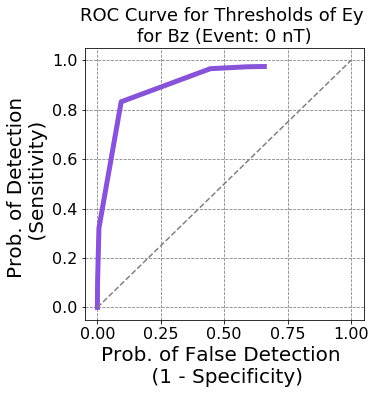

In [21]:
#plotting the ROC curve

fig = plt.figure(figsize=(5, 5))

#make grid
gs  = plt.GridSpec(1, 1, hspace=0.0, wspace=0.2, right = 0.9)

#add subplots
ax1 = fig.add_subplot(gs[0,0])

ax1.set_title('ROC Curve for Thresholds of Ey \n' + 
             'for Bz (Event: {} nT)'.format(DBound), 
             fontsize=18)

#set up titles for axis
ax1.set_xlabel('Prob. of False Detection \n (1 - Specificity)', fontsize = 20)
ax1.set_ylabel('Prob. of Detection \n (Sensitivity)', fontsize = 20)

#plot values
ax1.plot(perfValues['PFD'], perfValues['POD'],  color = '#8853d8', lw = 5.0)

#set up "random performance line"
ax1.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), ls = 'dashed', color = 'grey')
#set up grid
ax1.grid(color='gray', linestyle='dashed')

#set nice labelsizes
ax1.tick_params(labelsize = 16)

plt.savefig("ROC_curve.png")

plt.show()

#### Outside Source

 This indicates a strong correlation between the magnetic field Bz -component and the electric field Ey -component in the solar wind

https://www.researchgate.net/figure/Cross-wavelet-correlation-between-the-ACE-Bz-and-Ey-component-and-the-Cluster-thermal_fig5_234000988

### Heidske Skill Score

The Heidke Skill Score (HSS) is a measure of skill in forecasts. It is defined as follows: 

(NC - E) / (T - E)

In [22]:
N, F, M, H = confusion_matrix(hourOmni['Events'], hourOmni['Predict']).ravel()

print('True Positives: {}'.format(H), 'False Positives: {}'.format(F), '\n' 
      'False Negatives: {}'.format(M), 'True Negatives: {}'.format(N))


True Positives: 0 False Positives: 0 
False Negatives: 131686 True Negatives: 202802


In [23]:
skillScore = (2*(H*N-(F*M)))/((H+M)*(F+N)+(H+F)*(N+F))

In [24]:
skillScore

0.0

Note: The value is 0 because the last entry in 'Predict' is 0! However, the HSS peaks at 0.74, which is considered high!

### Fun Seaborn Plot

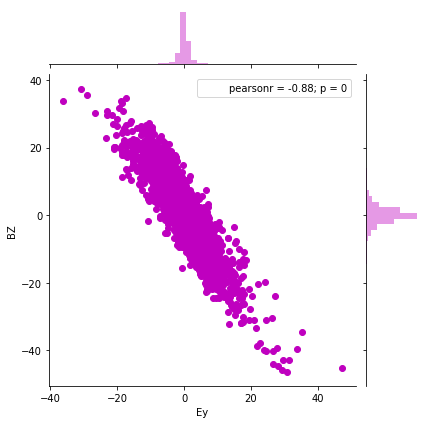

In [26]:
## Scatter plot + histograms
## automatically calculates pearson r-value!

sns.jointplot(x="Ey", y="BZ", data=hourOmni, color="m")

plt.show()